# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction
Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(x(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & d(t+1) = d(t) + v(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1) and a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$. 

In the following, we code this problem up with [PyTorch](https://pytorch.org/), which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.

--- 

## 2. Solution Asing a Better Problem Formulation

In order to formulate the problem into something much more comprehensive, we consider a case where we have batches of initial states between 0 and 1 generated randomly. We further add randomness to the position and velocity measurements. $w$ and $u$ represent the random noise in position and velocity respectively. The dynamics of the rocket with these modifications are as follows:  

$$
\begin{aligned}
\min_{\theta} \quad & \mathbb{E}_{\{w(t), u(t), x(0)\}}\left[||x(T)||^2\right] \\
\quad & d(t+1) = d(t) + v(t) + w(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) + u(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1 \\
\quad & x(1) \sim \Pr(x(1))
\end{aligned}
$$

Here $w(t) \sim \Pr(w(t))$ and $u(t) \sim \Pr(u(t))$ are modeled as i.i.d. noises added to the dynamics, and $\Pr(x(1))$ is the distribution of initial states. We will approximate this problem using samples from $\Pr(w(t))$, $\Pr(u(t))$, and $\Pr(x(1))$. To do so, we sample $\{w(1)^{(i)},w(2)^{(i)},...,w(T)^{(i)}\}_{i}^N$ from $\Pr(w(t))$,  $\{u(1)^{(i)},u(2)^{(i)},...,u(T)^{(i)}\}_{i}^N$ from $\Pr(u(t))$, and $\{x(0)^{(i)}\}_{i}^N$ from $\Pr(x(1))$, where $N$ is the number of samples to be considered. Then we have the following problem instead, where we optimize the loss function, which is just the mean squared loss of the state. The $\theta$ represents the neural network (controller) parameters. 

$$
\begin{aligned}
\min_{\theta} \quad & \frac{1}{N}\sum_{i=1}^N ||x^{(i)}(T)||^2 \\
\quad & d(t+1)^{(i)} = d(t)^{(i)} + v(t)^{(i)} + w(t)^{(i)} \Delta t, \\
\quad & v(t+1)^{(i)} = v(t)^{(i)} + a(t)^{(i)} + u(t)^{(i)} \Delta t, \\
\quad & a(t)^{(i)} = f_{\theta}(x(t)^{(i)}), ~\forall t=1,...,T-1, ~i=1,...,N \\
\end{aligned}
$$


We only generate random initial position for the rocket keeping the velocity at zero for all `N` cases. To do so, we add the following line of code during simulation initialization:

```
    def initialize_state():
        state_0 = t.rand((N, 1)) #position
        state_1 = t.zeros((N, 1)) #speed
        
        # concatenate into one tensor
        state = t.cat((state_0, state_1), dim=1)
        return state 
```

The sample python scripts to run the training and simulation for rocket landing are attached below for reference: 

In [1]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)


In [2]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.06  # landing platform height
ROTATION_ACCEL = 20  # rotation constant

In [56]:
# define system dynamics --> for randomness
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class RandomDynamics(nn.Module):

    def __init__(self):
        super(RandomDynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action
        
        # Add Randomness 
        w = t.tensor([1, 0])*t.tensor(np.random.uniform(0, 2e-2, 1)) # add random noise in the position 
        u = t.tensor([0, 0])*t.tensor(np.random.uniform(0, 2e-2,1)) # add random noise in the speed 
        noise =  (w+u) * FRAME_TIME

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])

        #state = t.matmul(step_mat, state.t()) 
        state = t.matmul(state, step_mat.t()) 
        
        return state + noise.float() # add noise to the measurement 

In [9]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)
    

        return state

In [10]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [38]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, N):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.N = N # added for random
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        #state = [1., 0.]  # TODO: need batch of initial states
        #state = t.rand(2)
        #state = t.zeros((N, 2))
        state_0 = t.rand((N, 1)) #position
        state_1 = t.zeros((N, 1)) #speed

        state = t.cat((state_0, state_1), dim=1)
        return state #t.tensor(state, requires_grad=False).float()

    def error(self, state):
        #return state[0]**2 + state[1]**2
        #return t.sum(t.mul(state, state))/self.N
    
        return t.mean(state**2)

In [54]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.SGD(self.parameters, momentum=0.9, lr = 0.001)
        #self.scheduler = StepLR(self.optimizer, step_size=20, gamma=10) # dynamic learning rate
        #self.optimizer = optim.LBFGS(self.parameters, lr = 0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            #self.scheduler.step() #dynamic learning rate
            if (epoch % 100 == 0):
                print('[%d] loss: %.3f' % (epoch + 1, loss))
        self.visualize()

    def visualize(self):
        data = np.array([[self.simulation.state_trajectory[i][N].detach().numpy() for i in range(self.simulation.T)] for N in range(self.simulation.N)])
        for i in range(self.simulation.N):
            x = data[i, :, 0]
            y = data[i, :, 1]
            plt.plot(x, y)
            plt.xlabel("Position")
            plt.ylabel("Velocity")
        plt.show()

#### Training - 1: Random Initial States Without Noise

We generate 30 random initial states of the rocket. We define a neural network controller with 2 inputs, 1 hidden layer with 10 neurons and 1 output layer with 1 neuron. The output of the neural network controller is the acceleration that the rocket accelerates with in the next time-step. Using LBFGS, the neural network parameters (weights and biases) are optimized so as to reach the final position of 0 and final velocity of 0. We first optimize the controller without adding random noise. 

The results are shown below: 

[1] loss: 1.364
[2] loss: 0.722
[3] loss: 0.419
[4] loss: 0.260
[5] loss: 0.174
[6] loss: 0.124
[7] loss: 0.091
[8] loss: 0.070
[9] loss: 0.055
[10] loss: 0.043
[11] loss: 0.034
[12] loss: 0.027
[13] loss: 0.016
[14] loss: 0.012
[15] loss: 0.008
[16] loss: 0.006
[17] loss: 0.006
[18] loss: 0.005
[19] loss: 0.005
[20] loss: 0.005
[21] loss: 0.005
[22] loss: 0.005
[23] loss: 0.004
[24] loss: 0.002
[25] loss: 0.002
[26] loss: 0.001
[27] loss: 0.001
[28] loss: 0.001
[29] loss: 0.000
[30] loss: 0.000
[31] loss: 0.000
[32] loss: 0.000
[33] loss: 0.000
[34] loss: 0.000
[35] loss: 0.000
[36] loss: 0.000
[37] loss: 0.000
[38] loss: 0.000
[39] loss: 0.000
[40] loss: 0.000
[41] loss: 0.000
[42] loss: 0.000
[43] loss: 0.000
[44] loss: 0.000
[45] loss: 0.000
[46] loss: 0.000
[47] loss: 0.000
[48] loss: 0.000
[49] loss: 0.000
[50] loss: 0.000


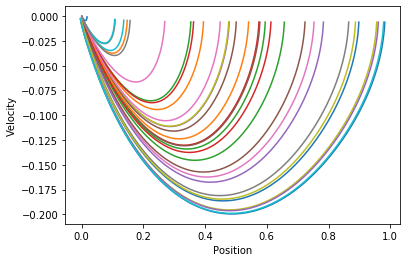

In [154]:
# Now it's time to run the code!
t.manual_seed(10)
N = 30 # number of samples  for random case
T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 1  # action space dimensions
d = RandomDynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation, N is the number of samples to be considered
o = Optimize(s)  # define optimizer
o.train(50)  # solve the optimization problem

We can see that the loss function (mean squared error of the states) converged to zero. The trajectory of the rockets look similar to the case with only 1 initial state. 

### Training - 2: Random Initial States With Noise

In order to mimic inconsistensies in the sensor measurements, we add uniform noise in the position and the velocity sensor of the rocket. We sample randomly from a uniform distribution between (0, 1e-3) and (0, 1e-4) for position and velocity noises. The added noise dynamics in the RandomDynamics() module is shown below: 
```
        w = t.tensor([1, 0])*t.tensor(np.random.uniform(0, 2e-2, 1)) # add random noise in the position 
        u = t.tensor([0, 1])*t.tensor(np.random.uniform(0, 2e-2, 1)) # add random noise in the speed 
        noise =  (w+u)
```

We run the optimization keeping all the remaining variables constant. For this optimization problem we use SGD (Stochastic Gradient Descent) algorithm with lr = 0.001 and momentum = 0.9. Momentum, in SGD, refers to the weight of the running average of the gradient. We train the model for 5000 iterations. 

[1] loss: 5.350
[101] loss: 0.026
[201] loss: 0.023
[301] loss: 0.020
[401] loss: 0.019
[501] loss: 0.015
[601] loss: 0.014
[701] loss: 0.013
[801] loss: 0.011
[901] loss: 0.010
[1001] loss: 0.011
[1101] loss: 0.009
[1201] loss: 0.012
[1301] loss: 0.008
[1401] loss: 0.007
[1501] loss: 0.009
[1601] loss: 0.008
[1701] loss: 0.008
[1801] loss: 0.006
[1901] loss: 0.008
[2001] loss: 0.007
[2101] loss: 0.006
[2201] loss: 0.007
[2301] loss: 0.006
[2401] loss: 0.007
[2501] loss: 0.007
[2601] loss: 0.006
[2701] loss: 0.006
[2801] loss: 0.007
[2901] loss: 0.006
[3001] loss: 0.007
[3101] loss: 0.006
[3201] loss: 0.006
[3301] loss: 0.006
[3401] loss: 0.007
[3501] loss: 0.006
[3601] loss: 0.006
[3701] loss: 0.006
[3801] loss: 0.007
[3901] loss: 0.007
[4001] loss: 0.006
[4101] loss: 0.006
[4201] loss: 0.006
[4301] loss: 0.007
[4401] loss: 0.006
[4501] loss: 0.007
[4601] loss: 0.006
[4701] loss: 0.006
[4801] loss: 0.007
[4901] loss: 0.007


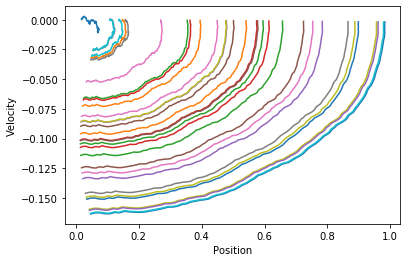

In [55]:
# Now it's time to run the code!
t.manual_seed(10)
N = 30 # number of samples  for random case
T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 1  # action space dimensions
d = RandomDynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation, N is the number of samples to be considered
o = Optimize(s)  # define optimizer
o.train(5000)  # solve the optimization problem

From the above plot, we see how noisy the trajectories are. We can see that the loss converged to 0.007 and the rockets were not able to reach to the ground fully. This is because the noise added to the system would always result in incorrect measurement in position and velocity of the rocket. The rocket might have landed successfully when in reality, due to the sensor noise, the results do not seem to be converged. 

### Discussion

In this project, we considered a rocket landing problem formulated as an optimization problem. Using a neural network controller that predicted the action (acceleration of the rocket) so as to safely land the rocket on the ground. The rocket is assumed to have landed safely if its final position and velocity is zero. In the figures below, 30 different samples were initialized for training so that the model is able to generalize to different initial position of the rocket. When noise was not added to the measurements (position and velocity), the controller was able to land the rockets safely. However, adding random noise to the measurements, the rockets were able to get closer to the ground, however, contained some negative (downward) velocity. 

   Trajectories without Noise          |  Trajectories with Noise
:-------------------------------------:|:-------------------------:
![No Noise](plot_1.png)  |  ![With Noise](plot_2.png)

## 4. Grading

* (30%) Documentation of the problem formulation: Clearly describe the objective function, the variables, the constraints, and the assumptions involved in formulating the problem.

* (40%) Programming: Like for homeworks, please push you code to your github repo. Please comment your code so that it is useful to you in the future.

* (30%) Analysis of the results: Please document the convergence and the optimal solutions (e.g., the state trajectory if it is a control problem).

* (Bonus 20%) Formulation of a problem different from rocket landing: The PyTorch framework can also be used for other engineering problems, e.g., for structure design with nonlinear mechanical properties. You get 20 bonus points for solving your own problems that are at least at the same level of difficulty as rocket landing. 